In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Direktori dataset
data_dir = r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\dataset\original'
data_dir_dcgan = r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\generated_images'

batch_size = 32
img_height = 280
img_width = 280

# Augmentasi Data
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

# Memuat dataset dari direktori asli
train_ds_original = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds_original = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Memuat dataset dari direktori DCGAN
train_ds_dcgan = tf.keras.utils.image_dataset_from_directory(
    data_dir_dcgan,
    validation_split=0.25,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds_dcgan = tf.keras.utils.image_dataset_from_directory(
    data_dir_dcgan,
    validation_split=0.25,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Menggabungkan dataset
train_ds = train_ds_original.concatenate(train_ds_dcgan)
test_ds = test_ds_original.concatenate(test_ds_dcgan)

# Mengambil nama kelas dari dataset asli
class_names_original = train_ds_original.class_names
class_names_dcgan = train_ds_dcgan.class_names

# Menggabungkan nama kelas dan memastikan unik
class_names = list(set(class_names_original + class_names_dcgan))
print(class_names)

In [ ]:
# Visualisasi contoh gambar
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Konfigurasi dataset untuk performa
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardisasi data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

# Membuat model dasar
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes)
])

# Kompilasi model
opt = tf.keras.optimizers.SGD()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Ringkasan model
model.summary()

# Melatih model
epochs = 50
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)

# Visualisasi hasil pelatihan
if 'accuracy' in history.history:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Metrik akhir
    final_train_acc = acc[-1]
    final_val_acc = val_acc[-1]
    final_train_loss = loss[-1]
    final_val_loss = val_loss[-1]

    print("\n")
    print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc * 100:.2f}%)")
    print(f"Final Testing Accuracy: {final_val_acc:.4f} ({final_val_acc * 100:.2f}%)")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Testing Loss: {final_val_loss:.4f}")

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Testing Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Testing Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Testing Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Testing Loss')
    plt.show()
else:
    print("No data available.")

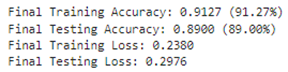

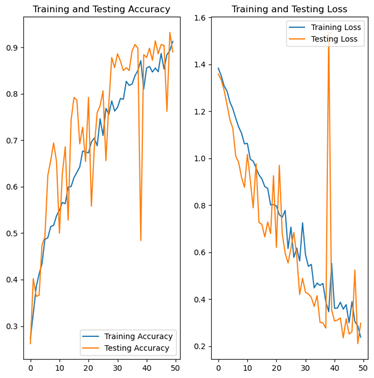

In [ ]:
# Menyimpan Model
model.save(r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\model\CNN Augmented by DCGAN\Augmented by DCGAN (SGD 50epochs) Applied Dropout-Copy1.h5')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Setelah pelatihan model
# Lakukan prediksi untuk testing set
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Konversi ke numpy array untuk memudahkan penanganan
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Hitung classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)

# Hitung TP, TN, FP, FN
def calculate_metrics(y_true, y_pred, num_classes):
    metrics = {
        'TP': np.zeros(num_classes),
        'TN': np.zeros(num_classes),
        'FP': np.zeros(num_classes),
        'FN': np.zeros(num_classes)
    }

    for i in range(num_classes):
        metrics['TP'][i] = np.sum((y_pred == i) & (y_true == i))
        metrics['TN'][i] = np.sum((y_pred != i) & (y_true != i))
        metrics['FP'][i] = np.sum((y_pred == i) & (y_true != i))
        metrics['FN'][i] = np.sum((y_pred != i) & (y_true == i))

    return metrics

# Hitung metrik
num_classes = len(class_names)
metrics = calculate_metrics(y_true, y_pred, num_classes)

# Tampilkan hasil TP, TN, FP, FN
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"True Positive (TP): {metrics['TP'][i]}")
    print(f"True Negative (TN): {metrics['TN'][i]}")
    print(f"False Positive (FP): {metrics['FP'][i]}")
    print(f"False Negative (FN): {metrics['FN'][i]}")

# Visualisasi confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Normalisasi confusion matrix
threshold = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > threshold else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model(r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\model\CNN Augmented by DCGAN\Augmented by DCGAN (SGD 50epochs) Applied Dropout-Copy1.h5')

# Load and preprocess the image
img_path = r'C:\Users\andre\ml-workspace\notebooks\Proyek Tugas Akhir\dataset\inference test\harusnya_kencur.jpeg'
img = tf.keras.utils.load_img(img_path, target_size=(280, 280))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Convert the image to a NumPy array for display
img_display = tf.keras.utils.img_to_array(img)  # Convert to array for display

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Define class names
class_names = ['jahe', 'kencur', 'kunyit', 'lengkuas']

# Determine the predicted class and confidence
predicted_class = class_names[np.argmax(score)]
confidence = 100 * np.max(score)
text = "This image most likely belongs to '{}' with a {:.2f}% confidence.".format(predicted_class, confidence)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(img_display.astype('uint8'))  # Convert to uint8 for proper display
plt.axis('off')

# Add text at the top of the image
plt.text(0.5, 1.05, text, ha='center', va='bottom', fontsize=10, transform=plt.gca().transAxes)

plt.show()

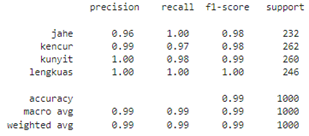

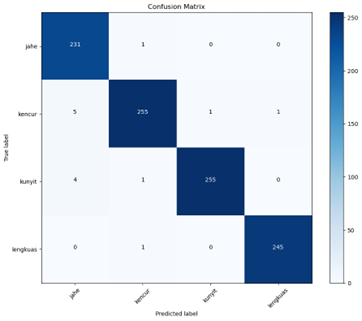

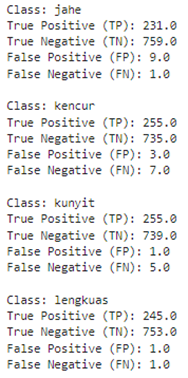